# Inflation Framing Analysis: Guardian, Telegraph & BBC (2022–2023)

## 1. Introduction
- Brief description of goals & hypotheses (H1, H2, H3)
- Summary of corpus (`cleaned_articles_2022_2023.csv`)

## 2. Exploratory Data Analysis (EDA)
### 2.1 Load data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import calendar
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models.phrases import Phrases, Phraser
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('data/cleaned_articles_2022_2023.csv')

df.head()

,Unnamed: 0.1,Unnamed: 0,Title,URL,Article_Text,Publication Date,Source,Sentiment Score,Year,Month,Article_Length
0,0,0,Bank of England governor says don't underestim...,https://www.bbc.co.uk/news/business-67474899,Andrew Bailey told MPs that Bank policymakers ...,2023-11-21,BBC,0.249234,2023,11,3813
1,1,1,Rishi Sunak: 'We've halved inflation' and othe...,https://www.bbc.co.uk/news/uk-politics-67475281,We've been looking at some of his claims. Rish...,2023-11-20,BBC,0.150736,2023,11,1898
2,2,2,Rachel Reeves: Labour would increase benefits ...,https://www.bbc.co.uk/news/uk-politics-67466971,"But before the champagne corks pop, everyone s...",2023-11-16,BBC,0.209527,2023,11,5023
3,3,3,What a falling inflation rate means for your f...,https://www.bbc.co.uk/news/business-67426526,When inflation started to accelerate early in ...,2023-11-15,BBC,0.396906,2023,11,3650
4,4,4,Why inflation is falling but prices are still ...,https://www.bbc.co.uk/news/business-64290160,The government had committed to better protect...,2023-11-15,BBC,0.250206,2023,11,3112


# Visualization Styling for Academic Paper

This notebook uses consistent styling across all visualizations to maintain a professional, publication-quality appearance throughout the paper. This includes:

- **Color Scheme**: Each media outlet has a consistent color representation:
 - BBC: Blue (#1f77b4)
 - Telegraph: Red (#d62728)
 - Guardian: Green (#2ca02c)

- **Formatting**: Consistent annotation styles, legends, and source citations across all figures

In [3]:
# Set up standardized visualization styling for the entire notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator

# Make sure visualizations directory exists
os.makedirs('visualisations', exist_ok=True)

def setup_visualization_style():
    """Set up consistent styling for all visualizations in the notebook"""
    # Use seaborn's professional whitegrid style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Set context for paper with larger font scale
    sns.set_context("paper", font_scale=1.3)
    
    # Set global matplotlib parameters for academic paper style
    plt.rcParams['figure.figsize'] = (12, 7)
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['font.family'] = 'serif'  # Academic style
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['grid.color'] = 'gray'
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['savefig.dpi'] = 300  # High resolution for all saved figures
    
    # Define standard color palette for sources
    source_colors = {
        'BBC': '#1f77b4',      # Blue
        'Telegraph': '#d62728', # Red
        'Guardian': '#2ca02c'   # Green
    }
    
    # Return the source colors for use in plots
    return source_colors

# Fix the save_figure function to ensure it saves to the visualisations folder
def save_figure(fig, filename_base):
    """Save figure with standard parameters for publication"""
    # Create directory if needed
    os.makedirs('visualisations', exist_ok=True)
    
    # Ensure the path includes the visualisations directory
    if not filename_base.startswith('visualisations/'):
        filename_base = f'visualisations/{filename_base}'
        
    # Save in multiple formats at high resolution
    fig.savefig(f'{filename_base}.pdf', bbox_inches='tight')
    print(f"Saved {filename_base}.pdf visualisation")

def add_source_note(fig, additional_text=""):
    """Add standardized source note to figure"""
    base_text = 'Source: UK media dataset (N=2,804), 2022-2023'
    if additional_text:
        base_text += f"; {additional_text}"
    fig.text(0.01, 0.01, base_text, fontsize=8, color='dimgray')

def format_legend(ax, title="Media Outlet"):
    """Apply standard legend formatting"""
    legend = ax.legend(title=title, frameon=True, fontsize=11,
                      framealpha=0.9, edgecolor='lightgray')
    legend.get_title().set_fontweight('bold')
    return legend

def format_axes(ax, x_label="", y_label="", title=""):
    """Apply standard axis formatting"""
    if x_label:
        ax.set_xlabel(x_label, fontsize=13, labelpad=10)
    if y_label:
        ax.set_ylabel(y_label, fontsize=13, labelpad=10)
    if title:
        ax.set_title(title, fontsize=16, pad=15)
    
    # Format date axes if x-axis contains dates
    if isinstance(ax.get_xlim()[0], float) and ax.get_xlim()[0] > 700000:  # Matplotlib date format check
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45)
    
    return ax

# Initialize the standard style and colors for the notebook
source_colors = setup_visualization_style()

print("Visualization style setup complete - all plots will use consistent academic styling")

Visualization style setup complete - all plots will use consistent academic styling


## 2. Exploratory Data Analysis (EDA)

In [4]:
# count number of bbc articles
bbc_count = df[df['Source'] == 'BBC'].shape[0]
print(f"Number of BBC articles: {bbc_count}")
# count number of guardian articles
guardian_count = df[df['Source'] == 'Guardian'].shape[0]
print(f"Number of Guardian articles: {guardian_count}")
# count number of telegraph articles
telegraph_count = df[df['Source'] == 'Telegraph'].shape[0]
print(f"Number of Telegraph articles: {telegraph_count}")

Number of BBC articles: 233
Number of Guardian articles: 1576
Number of Telegraph articles: 995



==== COMBINED INFLATION AND ARTICLE COUNT VISUALIZATION ====
Saved visualisations/inflation_article_count.pdf visualisation


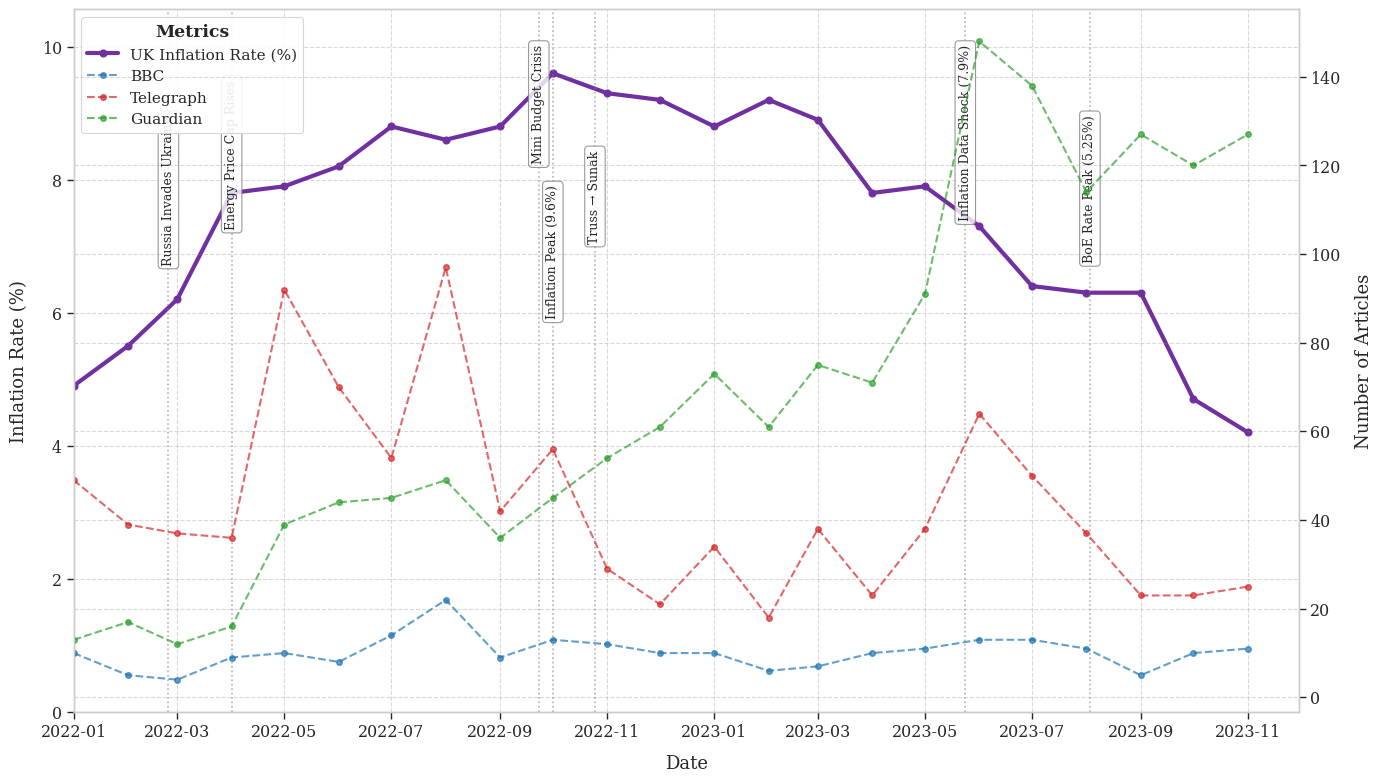

In [5]:
print("\n==== COMBINED INFLATION AND ARTICLE COUNT VISUALIZATION ====")

# Process the inflation data
lines = """
2022 JAN,4.9
2022 FEB,5.5
2022 MAR,6.2
2022 APR,7.8
2022 MAY,7.9
2022 JUN,8.2
2022 JUL,8.8
2022 AUG,8.6
2022 SEP,8.8
2022 OCT,9.6
2022 NOV,9.3
2022 DEC,9.2
2023 JAN,8.8
2023 FEB,9.2
2023 MAR,8.9
2023 APR,7.8
2023 MAY,7.9
2023 JUN,7.3
2023 JUL,6.4
2023 AUG,6.3
2023 SEP,6.3
2023 OCT,4.7
2023 NOV,4.2
"""

# Parse the inflation data
data_rows = []
for line in lines.strip().split('\n'):
    if line:
        try:
            date_str, rate_str = line.split(',')
            year = int(date_str.split()[0])
            month = date_str.split()[1]
            # Convert month name to month number
            month_num = {"JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6,
                         "JUL": 7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12}[month]
            rate = float(rate_str)
            data_rows.append({'Year': year, 'Month': month_num, 'Rate': rate})
        except:
            # Skip any problematic lines
            continue

inflation_df = pd.DataFrame(data_rows)

# Create a proper date column for inflation data
inflation_df['Date'] = pd.to_datetime(inflation_df[['Year', 'Month']].assign(day=1))

# Prepare article count data
# Ensure we have monthly counts by source
if 'monthly_counts' not in locals():
    monthly_counts = df.groupby(['Year', 'Month', 'Source']).size().reset_index(name='Count')
    monthly_counts['Date'] = pd.to_datetime(monthly_counts[['Year', 'Month']].assign(day=1))
    monthly_counts = monthly_counts.sort_values('Date')

# Create a dual-axis figure
fig, ax1 = plt.subplots(figsize=(14, 8))

# Format first axis using the standard function
format_axes(ax1, 
           x_label="Date", 
           y_label="Inflation Rate (%)")

# Plot inflation data
ax1.plot(inflation_df['Date'], inflation_df['Rate'], 
         color='#7030A0', linewidth=3, marker='o', 
         label='UK Inflation Rate (%)')

# Set y-axis limits for inflation
ax1.set_ylim(bottom=0)
ax1.set_ylim(top=max(inflation_df['Rate']) * 1.1)  # Give some headroom

# Second axis: Article counts (right y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Articles', fontsize=13, labelpad=10)

# Plot article counts by source
for source in df['Source'].unique():
    source_data = monthly_counts[monthly_counts['Source'] == source]
    # Make sure dates are in datetime format and sorted
    source_data = source_data.sort_values('Date')
    ax2.plot(source_data['Date'], source_data['Count'], 
             marker='o', markersize=4,
             linewidth=1.5, linestyle='--', label=source, 
             color=source_colors[source], alpha=0.7)

# Set date range to match (Jan 2022 - Nov 2023)
ax1.set_xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-11-30'))

# Add annotations for key economic events
key_events = {
    '2022-02-24': 'Russia Invades Ukraine',
    '2022-04-01': 'Energy Price Cap Rises',
    '2022-09-23': 'Mini Budget Crisis',
    '2022-10-25': 'Truss → Sunak',
    '2022-10-01': 'Inflation Peak (9.6%)',
    '2023-05-24': 'Inflation Data Shock (7.9%)',
    '2023-08-03': 'BoE Rate Peak (5.25%)'
}

# Define varying y-positions to prevent overlap
y_positions = {
    'Russia Invades Ukraine': 0.85,
    'Energy Price Cap Rises': 0.90,
    'Mini Budget Crisis': 0.95,
    'Truss → Sunak': 0.80,
    'Inflation Peak (9.6%)': 0.75,
    'Inflation Data Shock (7.9%)': 0.95,
    'BoE Rate Peak (5.25%)': 0.85
}

# Add event annotations
for date_str, label in key_events.items():
    date = pd.to_datetime(date_str)
    ax1.axvline(x=date, color='gray', linestyle=':', alpha=0.6)
    # Position label with varying heights
    y_pos = ax1.get_ylim()[1] * y_positions[label]
    ax1.annotate(label, xy=(date, y_pos), xytext=(0, 0), 
                textcoords="offset points", rotation=90, 
                fontsize=9, ha='center', va='top',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Create a custom legend with all items
combined_legend = ax1.legend(lines1 + lines2, labels1 + labels2, 
                             loc='upper left', title="Metrics", 
                             frameon=True, fontsize=11, 
                             framealpha=0.9, edgecolor='lightgray')
combined_legend.get_title().set_fontweight('bold')
# Adjust layout
plt.tight_layout()

# Save the figure using the standard function
save_figure(fig, "inflation_article_count")

Saved visualisations/avg_word_count_by_source.pdf visualisation


/var/folders/tz/m04h080x4rgdtp4hkk46mfq40000gn/T/ipykernel_45327/1427329682.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


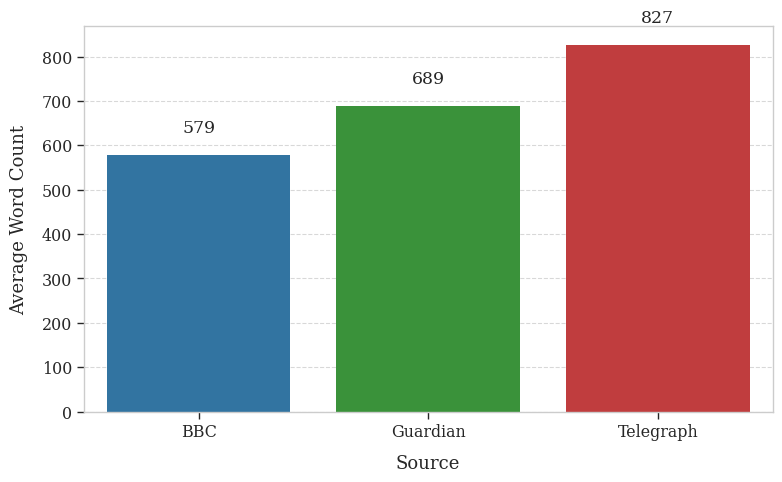

In [6]:
#------------------------------
# 3. ARTICLE LENGTH BY SOURCE
#------------------------------

# Calculate article length 
if 'Article_Length' not in df.columns:
    df['Article_Length'] = df['Article_Text'].str.len()

if 'Word_Count' not in df.columns:
    df['Word_Count'] = df['Article_Text'].apply(lambda x: len(str(x).split()))

# Calculate article length statistics by source
length_stats = df.groupby('Source').agg({
    'Article_Length': ['mean', 'median', 'min', 'max', 'count'],
    'Word_Count': ['mean', 'median', 'min', 'max']
})

# Format for readability
length_stats_formatted = pd.DataFrame({
    'Number of Articles': length_stats[('Article_Length', 'count')],
    'Average Length (chars)': length_stats[('Article_Length', 'mean')].round(0).astype(int),
    'Average Word Count': length_stats[('Word_Count', 'mean')].round(0).astype(int),
    'Median Word Count': length_stats[('Word_Count', 'median')].round(0).astype(int),
    'Min Word Count': length_stats[('Word_Count', 'min')].round(0).astype(int),
    'Max Word Count': length_stats[('Word_Count', 'max')].round(0).astype(int)
})

# Create figure with standardized styling
fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=length_stats_formatted.index,
    y=length_stats_formatted['Average Word Count'],
    palette=[source_colors['BBC'], source_colors['Guardian'], source_colors['Telegraph']]
)

# Add value labels on top of bars
for i, v in enumerate(length_stats_formatted['Average Word Count']):
    ax.text(i, v + 50, str(v), ha='center')

# Format axes using your standardized function
format_axes(ax, 
           x_label="Source", 
           y_label="Average Word Count")

# Adjust layout
plt.tight_layout()

# Save using your standardized function
save_figure(fig, "avg_word_count_by_source")


==== TOP WORDS BY SOURCE VISUALIZATION ====


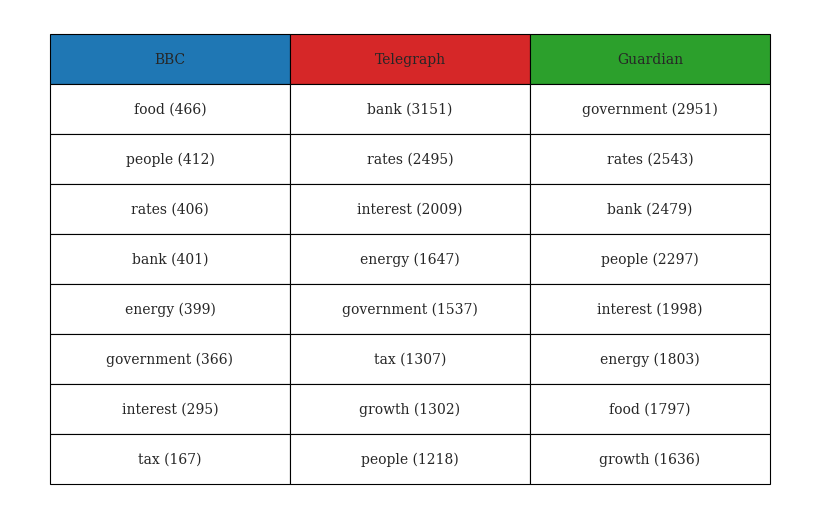

In [7]:
#------------------------------
# 4. TOP 8 WORDS BY SOURCE
#------------------------------

import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

print("\n==== TOP WORDS BY SOURCE VISUALIZATION ====")

# Define stopwords to exclude
stopwords = set([
    'the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'by', 'this',
    'with', 'it', 'are', 'as', 'was', 'but', 'be', 'at', 'from', 'has', 'have',
    'had', 'an', 'will', 'they', 'their', 'not', 'which', 'or', 'we', 'you', 
    'one', 'all', 'would', 'there', 'been', 'if', 'more', 'when', 'who', 'what',
    'also', 'said', 'its', 'into', 'than', 'other', 'can', 'only', 'about', 'may',
    'some', 'could', 'should', 'his', 'her', 'our', 'up', 'were', 'out', 'then',
    'time', 'them', 'just', 'such', 'how', 'these', 'any', 'two', 'per', 'cent',
    'now', 'over', 'like', 'even', 'those', 'after', 'first', 'new', 'many',
    'year', 'years', 'last', 'month', 'months', 'week', 'weeks', 'day', 'days',
    'inflation', 'prices', 'high', 'low', 'rise', 'fall', 'increase', 'decrease', 
    'rate', 'cost', 'price', 'costs', 'pay', 'higher', 'while', 'she', 'since', 
    'england', 'rises', 'down', 'rising', 'economy', 'says', 'living', 'figures', 'much', 'expected', 'less', 'still'
])

# Text preprocessing function
def preprocess_for_word_count(text):
    if not isinstance(text, str):
        return []
    
    # Lowercase and remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # Split into tokens, remove stopwords and short words
    tokens = [word for word in text.split() if word not in stopwords and len(word) > 2]
    
    return tokens

# Process text and count words by source
source_words = {}
for source in df['Source'].unique():
    # Combine all text from this source
    source_text = ' '.join(df[df['Source'] == source]['Article_Text'].fillna(''))
    
    # Process and count words
    tokens = preprocess_for_word_count(source_text)
    word_counts = Counter(tokens)
    top_words = word_counts.most_common(8)
    source_words[source] = top_words

# Create a DataFrame for the top words
top_words_df = pd.DataFrame(index=range(8), columns=df['Source'].unique())
for source, words in source_words.items():
    top_words_df[source] = [f"{word} ({count})" for word, count in words]

# Create figure with minimal dimensions - just enough for the table
fig = plt.figure(figsize=(8, 5))  # Reduced height significantly
ax = plt.subplot(111)
ax.axis('off')

# Set figure background to transparent
fig.patch.set_alpha(0.0)

# Use the standard source colors for column headers
col_colors = [source_colors.get(source, '#EEEEEE') for source in top_words_df.columns]

# Create table with the data - adjust the table to fill most of the space
table = ax.table(
    cellText=top_words_df.values,
    colLabels=top_words_df.columns,
    cellLoc='center',
    loc='center',
    colColours=col_colors,
    bbox=[0.05, 0.05, 0.9, 0.9]  # Table fills 90% of the figure area
)

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)  # Slightly smaller font to fit better
table.scale(1, 1.2)  # Slightly reduced row height for less vertical space

# Eliminated title and other elements that add space

# Set extremely tight layout with minimal padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # No margins at all

# Save the figure with minimal padding and tight bounding box
plt.savefig("visualisations/top_words_by_source.pdf", 
           bbox_inches='tight', 
           pad_inches=0.05,  # Minimal padding
           transparent=True)  # Transparent background

## Sentiment Analysis

In [8]:
# First, make sure the required imports are present
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm

# Check if MPS (Metal Performance Shaders) is available on your Mac
mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
device = torch.device("mps") if mps_available else torch.device("cpu")
print(f"Using device: {device}")

# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.to(device)  # Move model to GPU

# Define the sentiment analysis function
def analyze_sentiment_batched(texts, max_length=512, batch_size=16):
    results = []
    
    # Process in batches to avoid memory issues
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize
        encoded = tokenizer(batch_texts, 
                           padding=True, 
                           truncation=True, 
                           max_length=max_length, 
                           return_tensors="pt")
        
        # Move to MPS device
        encoded = {k: v.to(device) for k, v in encoded.items()}
        
        # Inference
        with torch.no_grad():
            outputs = model(**encoded)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
            predictions = predictions.cpu().numpy()
        
        # Save results
        for j, pred in enumerate(predictions):
            results.append({
                'negative': float(pred[0]),
                'neutral': float(pred[1]),
                'positive': float(pred[2]),
                'compound': float(pred[2] - pred[0])  # Similar to VADER's compound
            })
    
    return results

Using device: mps


/opt/anaconda3/envs/ds202/lib/python3.9/site-packages/huggingface_hub-0.29.2-py3.8.egg/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
/opt/anaconda3/envs/ds202/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/ds202/lib/python3.9/site-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models

In [9]:
# 1. Preprocess the articles
df['Analysis_Text'] = df['Article_Text'].fillna("")
df['Analysis_Text'] = df['Analysis_Text'].astype(str)

# Optional: truncate very long articles
df['Analysis_Text'] = df['Analysis_Text'].apply(lambda x: x[:50000] if len(x) > 50000 else x)

# 2. Extract processed article texts
article_texts = df['Analysis_Text'].tolist()

# 3. Run the analysis with verbose output
print(f"Running FinBERT sentiment analysis on {len(article_texts)} articles...")
sentiments = analyze_sentiment_batched(article_texts, batch_size=16)
print(f"Analysis complete. Generated {len(sentiments)} sentiment results.")

# 4. Add to dataframe with error checking
if len(sentiments) == len(df):
    df['finbert'] = sentiments
    df['finbert_compound'] = df['finbert'].apply(lambda x: x['compound'])
    df['finbert_positive'] = df['finbert'].apply(lambda x: x['positive'])
    df['finbert_negative'] = df['finbert'].apply(lambda x: x['negative'])
    df['finbert_neutral'] = df['finbert'].apply(lambda x: x['neutral'])
    
    # Print summary statistics
    print("\nSentiment summary by source:")
    print(df.groupby('Source')['finbert_compound'].agg(['count', 'mean', 'std', 'min', 'max']))
else:
    print(f"ERROR: Number of sentiment results ({len(sentiments)}) doesn't match number of articles ({len(df)})")

# 5. Save results 
df[['Source', 'Publication Date', 'Title', 'finbert_compound', 
    'finbert_positive', 'finbert_negative', 'finbert_neutral']].to_csv(
    'sentiment_results_finbert.csv', index=False)

print("FinBERT analysis complete!")

Running FinBERT sentiment analysis on 2804 articles...


  0%|          | 0/176 [00:00<?, ?it/s]

Analysis complete. Generated 2804 sentiment results.

Sentiment summary by source:
           count      mean       std       min       max
Source                                                  
BBC          233 -0.021335  0.327627 -0.923520  0.854406
Guardian    1576  0.062340  0.348657 -0.934825  0.913130
Telegraph    995  0.081011  0.310383 -0.926223  0.880034
FinBERT analysis complete!


Saved visualisations/average_sentiment_by_source.pdf visualisation


/var/folders/tz/m04h080x4rgdtp4hkk46mfq40000gn/T/ipykernel_45327/2987398140.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Source', y='mean', data=sentiment_by_source,


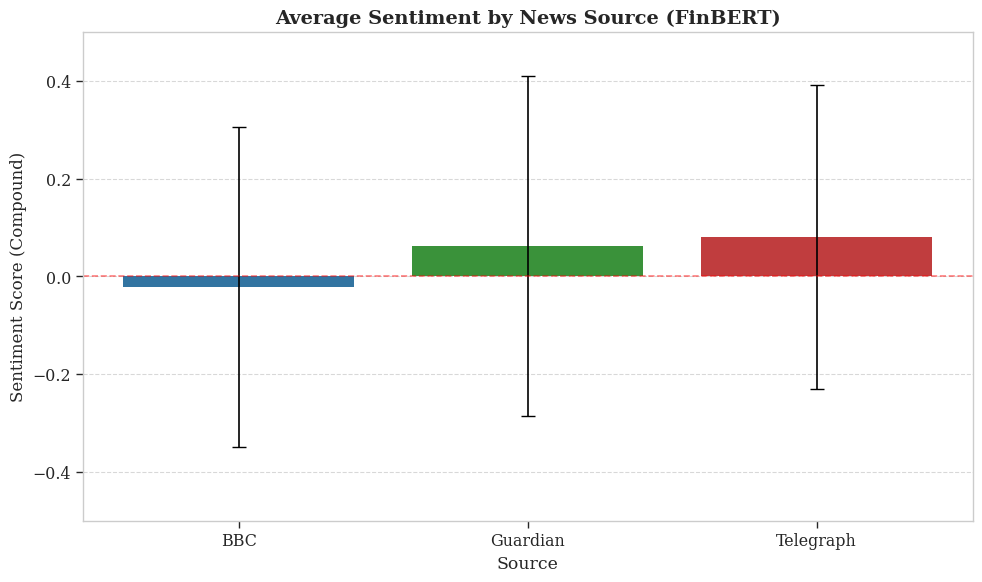

In [10]:
# Calculate average sentiment by source
sentiment_by_source = df.groupby('Source')['finbert_compound'].agg(['mean', 'median', 'std']).reset_index()

# Create a visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Source', y='mean', data=sentiment_by_source, 
                palette=[source_colors[s] for s in sentiment_by_source['Source']])

# Add error bars
for i, row in sentiment_by_source.iterrows():
    ax.errorbar(i, row['mean'], yerr=row['std'], color='black', capsize=5)

plt.title('Average Sentiment by News Source (FinBERT)', fontsize=14)
plt.ylabel('Sentiment Score (Compound)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Neutral line
plt.ylim(-0.5, 0.5)  # Adjust as needed
plt.tight_layout()
save_figure(plt.gcf(), "visualisations/average_sentiment_by_source")

Topic Modelling

[nltk_data] Downloading package stopwords to /Users/maxwellfilip-
[nltk_data]     turner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/maxwellfilip-
[nltk_data]     turner/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/maxwellfilip-
[nltk_data]     turner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/maxwellfilip-
[nltk_data]     turner/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Preprocessing articles for topic modeling...
Creating document-term matrix with phrase detection...
Number of phrases detected: 95
Sample phrases: ['amid cost_of_living_crisis', 'bailey governor bank_of_england', 'bank monetary_policy', 'bank monetary_policy committee', 'bank_of_england', 'bank_of_england chief', 'bank_of_england forecast', 'bank_of_england governor', 'bank_of_england governor andrew', 'bank_of_england monetary_policy']
Building LDA model with 5 topics...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usi

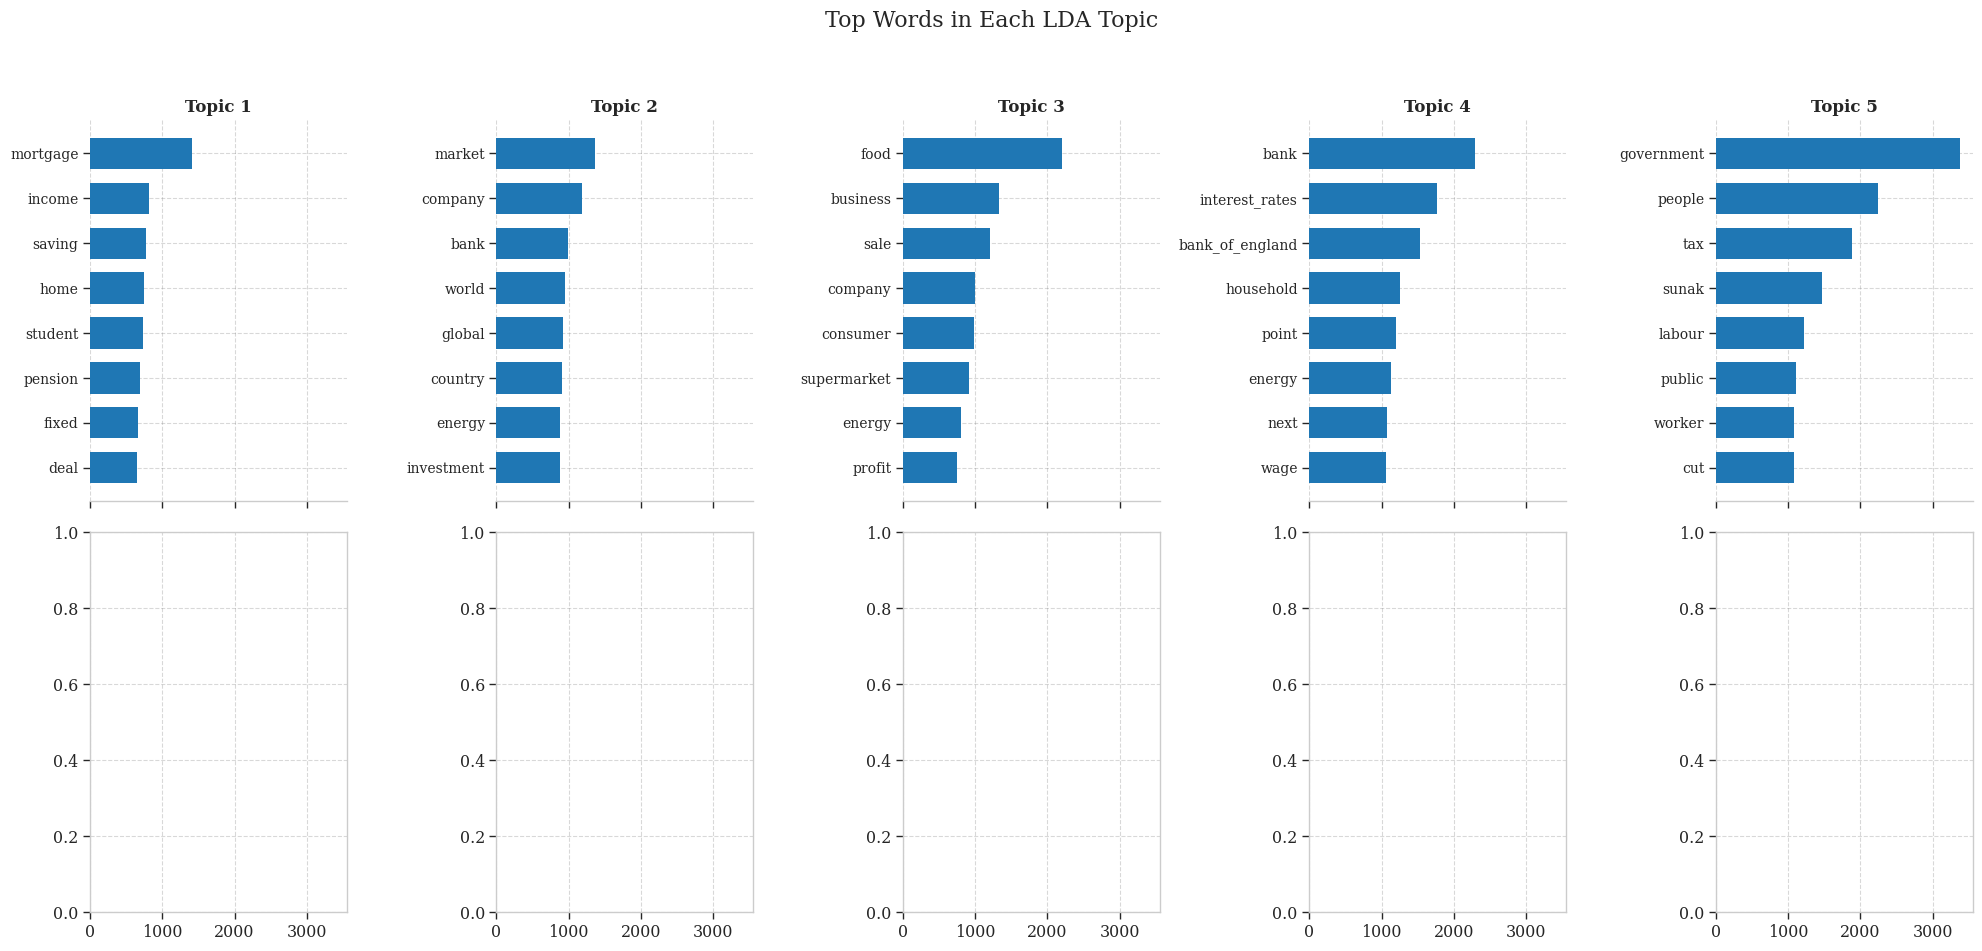

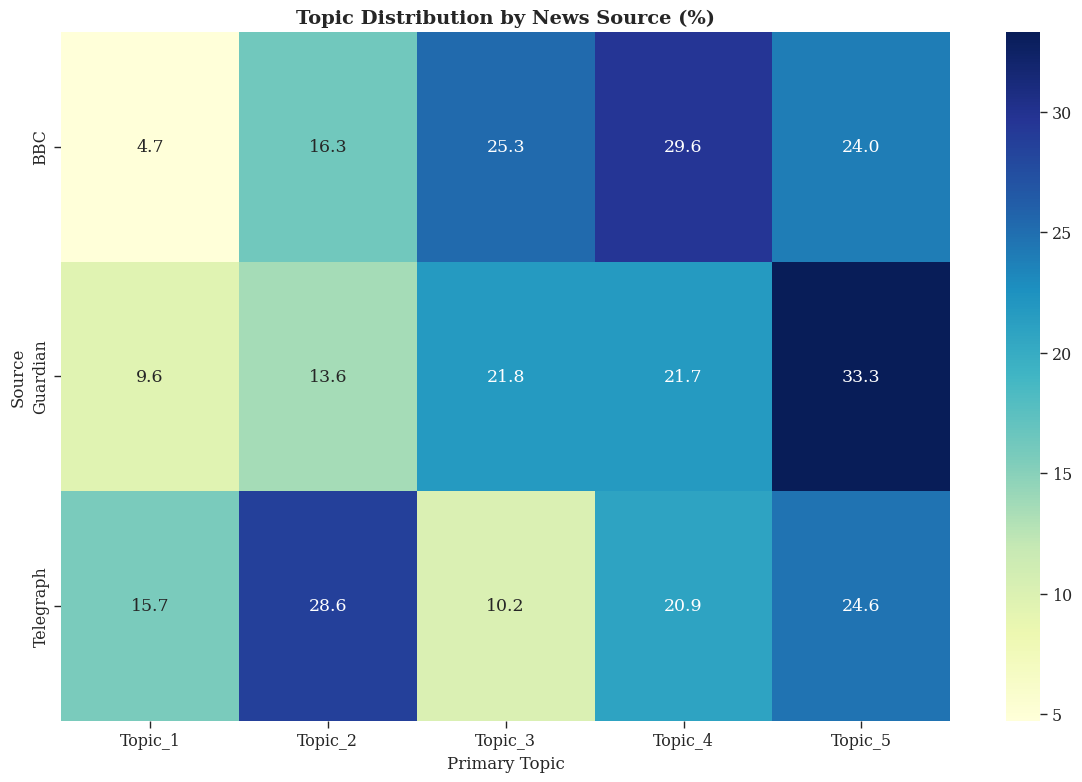

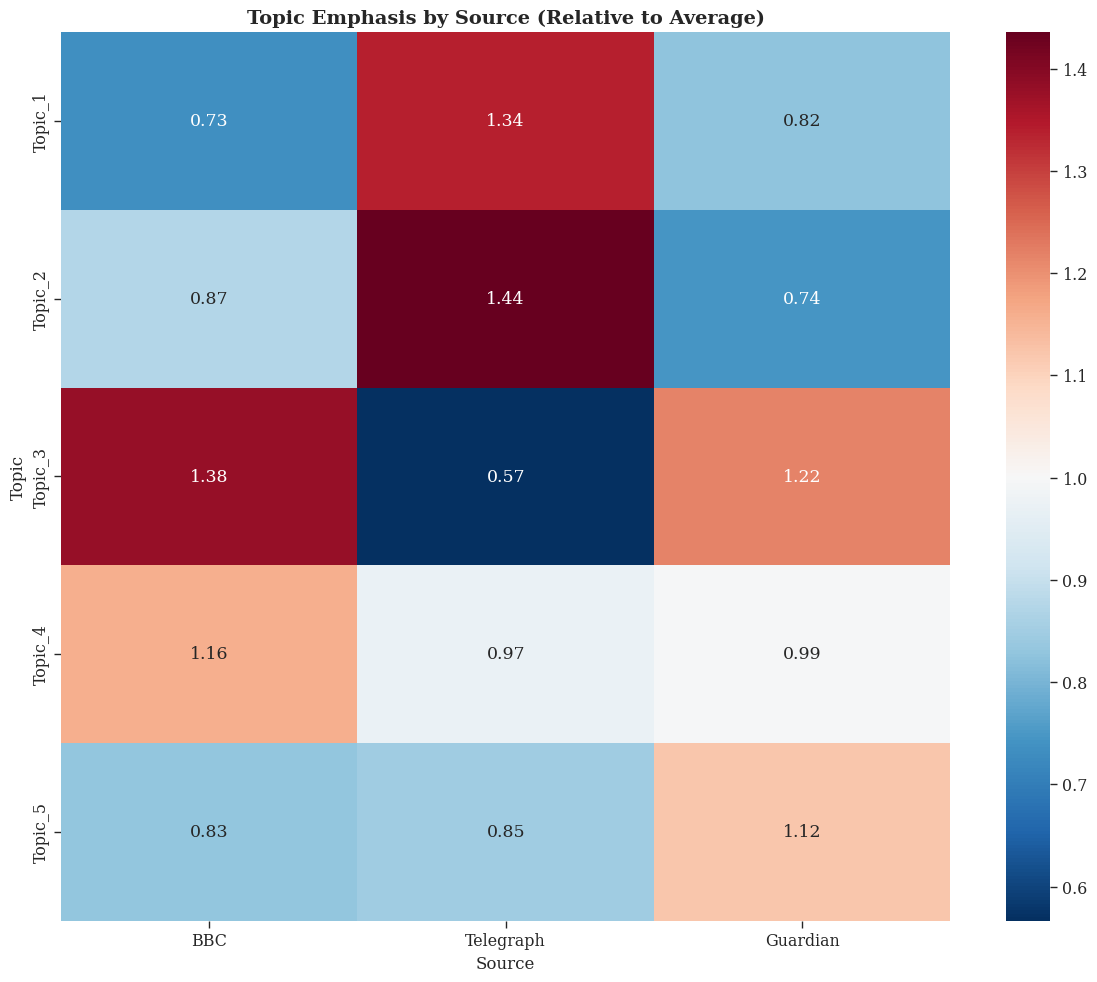

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models.phrases import Phrases, Phraser
from tqdm.notebook import tqdm

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

# Define important phrases you want to preserve
IMPORTANT_PHRASES = [
    'cost of living', 'living crisis', 'cost of living crisis',
    'interest rates', 'interest rate', 'bank of england',
    'energy prices', 'food prices', 'supply chain',
    'monetary policy', 'fiscal policy', 'central bank',
    'prime minister', 'chancellor of the exchequer', 'mini budget',
    'energy cap', 'price cap', 'disposable income',
    'financial markets', 'stock market', 'labour market',
    'household income', 'wages growth', 'wage growth',
    'recession risk', 'economic growth', 'consumer spending',
    'inflation target', 'gas prices', 'oil prices',
    'ukraine war', 'russia ukraine', 'global inflation',
    'tax cuts', 'government spending', 'public sector',
    'mortgage rates', 'housing market', 'rental market'
]

# Text preprocessing including phrase detection
def preprocess_text_with_phrases(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace important phrases with connected versions
    for phrase in IMPORTANT_PHRASES:
        connected_phrase = phrase.replace(' ', '_')
        text = text.replace(phrase, connected_phrase)
    
    # Remove punctuation while preserving the underscores in phrases
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Add specific individual stopwords for your domain
    custom_stopwords = {'inflation', 'price', 'prices', 'rate', 'rates', 'rise', 'rises', 
                      'rising', 'increase', 'increases', 'increasing', 'cost', 'costs',
                      'the', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that', 'by', 'this',
                      'with', 'it', 'are', 'as', 'was', 'but', 'be', 'at', 'from', 'has', 'have',
                      'had', 'an', 'will', 'they', 'their', 'not', 'which', 'or', 'we', 'you', 
                      'one', 'all', 'would', 'there', 'been', 'if', 'more', 'when', 'who', 'what',
                      'also', 'said', 'its', 'into', 'than', 'other', 'can', 'only', 'about', 'may',
                      'some', 'could', 'should', 'his', 'her', 'our', 'up', 'were', 'out', 'then',
                      'time', 'them', 'just', 'such', 'how', 'these', 'any', 'two', 'per', 'cent',
                      'now', 'over', 'like', 'even', 'those', 'after', 'first', 'new', 'many',
                      'year', 'years', 'last', 'month', 'months', 'week', 'weeks', 'day', 'days',
                      'inflation', 'prices', 'high', 'low', 'rise', 'fall', 'increase', 'decrease', 
                      'rate', 'price', 'costs', 'pay', 'higher', 'while', 'she', 'since', 
                      'england', 'rises', 'down', 'rising', 'economy', 'says', 'figures', 
                      'much', 'expected', 'less', 'still', 'average', 'economics', 'economist', 'growth'}
    stop_words.update(custom_stopwords)
    
    # Tokenize and filter
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    
    # Lemmatize words (but skip the connected_phrases)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in tokens:
        if '_' in token:  # This is a preserved phrase
            lemmatized_tokens.append(token)
        else:
            lemmatized_tokens.append(lemmatizer.lemmatize(token))
    
    return ' '.join(lemmatized_tokens)

# Apply preprocessing to each article
print("Preprocessing articles for topic modeling...")
df['processed_text'] = df['Article_Text'].apply(preprocess_text_with_phrases)

# Create a document-term matrix with bigram and trigram detection
print("Creating document-term matrix with phrase detection...")
# Add our preserved phrases as ngrams to be recognized by the vectorizer
ngram_range = (1, 3)  # Include unigrams, bigrams, and trigrams
vectorizer = CountVectorizer(
    max_features=5000, 
    min_df=5, 
    max_df=0.9,
    ngram_range=ngram_range,
    token_pattern=r'(?u)\b[\w_]+\b'  # This pattern allows for underscore in tokens
)
dtm = vectorizer.fit_transform(df['processed_text'])
feature_names = vectorizer.get_feature_names_out()

# Check if our phrases were detected
phrase_features = [f for f in feature_names if '_' in f]
print(f"Number of phrases detected: {len(phrase_features)}")
print("Sample phrases:", phrase_features[:10] if phrase_features else "None found")

# Set number of topics
num_topics = 5  # Adjust based on your domain knowledge

# Build the LDA model
print(f"Building LDA model with {num_topics} topics...")
lda_model = LatentDirichletAllocation(
    n_components=num_topics, 
    random_state=42,
    max_iter=25, 
    learning_method='online',
    n_jobs=-1  # Use all available cores
)
lda_model.fit(dtm)

# Visualize top words for each topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < 5:  # Only plot the first 5 topics
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 12})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=10)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
    
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('visualisations/lda_top_words.pdf', bbox_inches='tight')
    return fig

# Create topic visualization
topic_vis = plot_top_words(lda_model, feature_names, 8, 'Top Words in Each LDA Topic')

# Get topic keywords for each topic
topic_keywords = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_keywords_idx = topic.argsort()[:-11:-1]  # Get top 10 keywords
    top_keywords = [feature_names[i] for i in top_keywords_idx]
    # Replace underscores with spaces for readability in the output
    readable_keywords = [kw.replace('_', ' ') for kw in top_keywords]
    topic_keywords.append(readable_keywords)
    print(f"Topic {topic_idx+1}: {', '.join(readable_keywords)}")

# Transform documents to get topic distributions
doc_topic_dist = lda_model.transform(dtm)

# Add topic distributions to dataframe
topic_names = [f"Topic_{i+1}" for i in range(num_topics)]
topic_df = pd.DataFrame(doc_topic_dist, columns=topic_names)
df_with_topics = pd.concat([df.reset_index(drop=True), topic_df], axis=1)

# Assign a primary topic to each document
df_with_topics['Primary_Topic'] = df_with_topics[topic_names].idxmax(axis=1)

# Analyze topic distribution by source
topic_by_source = pd.crosstab(
    df_with_topics['Source'], 
    df_with_topics['Primary_Topic'], 
    normalize='index'  # Normalize by row (source)
) * 100  # Convert to percentage

# Create a heatmap of topic distribution by source
plt.figure(figsize=(12, 8))
sns.heatmap(topic_by_source, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Topic Distribution by News Source (%)', fontsize=14)
plt.ylabel('Source', fontsize=12)
plt.xlabel('Primary Topic', fontsize=12)
plt.tight_layout()
plt.savefig('visualisations/topic_distribution_by_source.pdf', bbox_inches='tight')

# Save topic keywords (with spaces restored for readability)
topic_keywords_df = pd.DataFrame({
    'Topic': [f"Topic_{i+1}" for i in range(num_topics)],
    'Keywords': [', '.join(keywords) for keywords in topic_keywords]
})
topic_keywords_df.to_csv('topic_keywords.csv', index=False)

# Advanced analysis: Create a topic preference index
# This shows which topics each source emphasizes more than the average
topic_overall_dist = df_with_topics[topic_names].mean()
topic_preference = pd.DataFrame()

for source in df['Source'].unique():
    source_df = df_with_topics[df_with_topics['Source'] == source]
    source_topic_dist = source_df[topic_names].mean()
    
    # Calculate how much this source emphasizes each topic compared to overall average
    # Value > 1 means the source emphasizes this topic more than average
    source_preference = source_topic_dist / topic_overall_dist
    topic_preference[source] = source_preference

# Create a heatmap of topic preferences
plt.figure(figsize=(12, 10))
sns.heatmap(topic_preference, annot=True, cmap='RdBu_r', center=1.0, fmt='.2f')
plt.title('Topic Emphasis by Source (Relative to Average)', fontsize=14)
plt.ylabel('Topic', fontsize=12)
plt.xlabel('Source', fontsize=12)
plt.tight_layout()
plt.savefig('visualisations/topic_emphasis_by_source.pdf', bbox_inches='tight')

print("Topic modeling with phrase detection complete!")

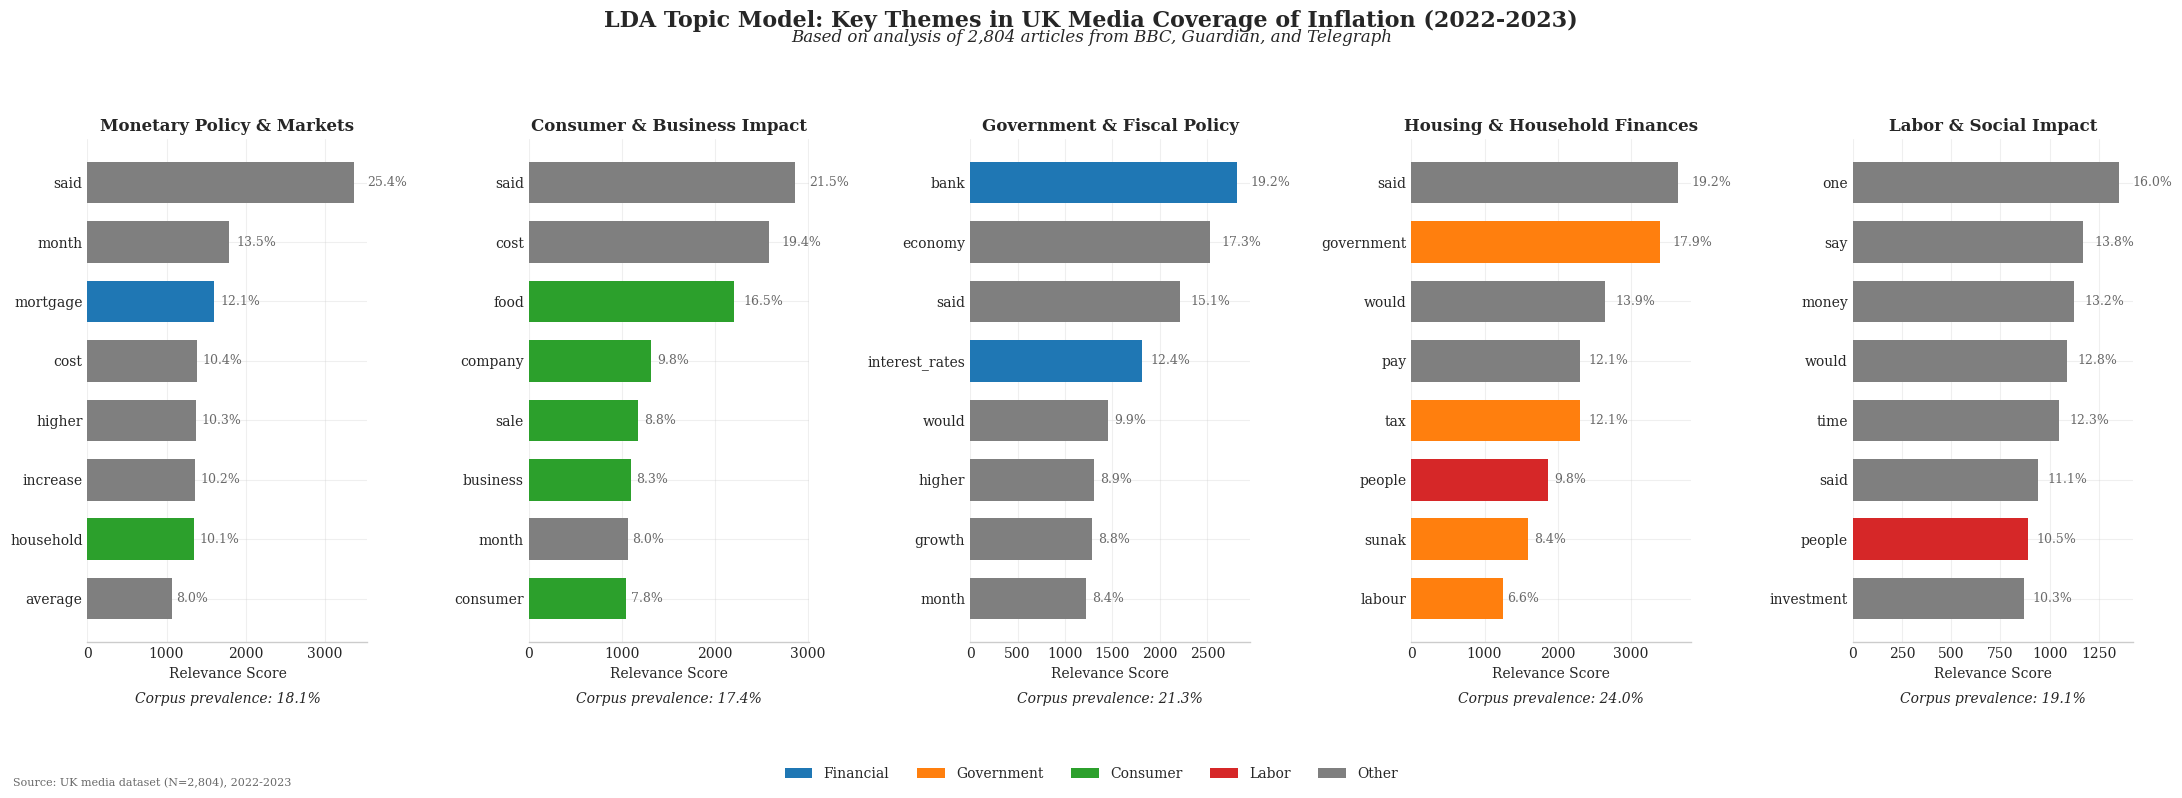

In [15]:
def plot_improved_lda_topics(model, feature_names, n_top_words, title):
    # Define meaningful topic names
    topic_labels = {
        "Topic 1": "Monetary Policy & Markets",
        "Topic 2": "Consumer & Business Impact",
        "Topic 3": "Government & Fiscal Policy",
        "Topic 4": "Housing & Household Finances",
        "Topic 5": "Labor & Social Impact"
    }
    
    # Define word categories for color coding
    financial_terms = ['bank', 'interest_rates', 'market', 'mortgage', 'saving', 'economic',
                      'bank_of_england', 'global', 'recession', 'point', 'economist']
    government_terms = ['government', 'tax', 'sunak', 'chancellor', 'labour', 'tory',
                       'pension', 'next', 'cut']
    consumer_terms = ['food', 'energy', 'consumer', 'household', 'supermarket', 'company',
                     'business', 'sale', 'profit', 'customer', 'bill']
    labor_terms = ['worker', 'union', 'strike', 'work', 'people', 'service', 'student']
    
    # Function to get color based on word
    def get_word_color(word):
        if word in financial_terms:
            return '#1f77b4'  # Blue
        elif word in government_terms:
            return '#ff7f0e'  # Orange
        elif word in consumer_terms:
            return '#2ca02c'  # Green
        elif word in labor_terms:
            return '#d62728'  # Red
        else:
            return '#7f7f7f'  # Gray
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 5, figsize=(22, 8), sharex=False)
    axes = axes.flatten()
    
    # Set consistent style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.titleweight'] = 'bold'
    
    # Plot each topic
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < 5:  # Only process the first 5 topics
            ax = axes[topic_idx]
            
            # Get top words and weights
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            
            # Calculate percentage of total weight
            normalized_weights = weights / weights.sum() * 100
            
            # Plot horizontal bars with appropriate colors
            for i, (word, weight) in enumerate(zip(top_features, weights)):
                ax.barh(i, weight, height=0.7, color=get_word_color(word))
                # Add percentage label next to each bar
                ax.text(weight + weight*0.05, i, f"{normalized_weights[i]:.1f}%", 
                       va='center', fontsize=9, color='dimgray')
            
            # Set labels and titles
            ax.set_title(f"{topic_labels[f'Topic {topic_idx+1}']}", fontdict={'fontsize': 12})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=10)
            
            # Remove top, right, and left spines
            for spine in ['top', 'right', 'left']:
                ax.spines[spine].set_visible(False)
            
            # Add y-tick labels (words)
            ax.set_yticks(range(len(top_features)))
            ax.set_yticklabels(top_features)
            
            # Set x-axis label
            ax.set_xlabel("Relevance Score", fontsize=10)
            
            # Add topic prevalence
            topic_prevalence = df_with_topics[f'Topic_{topic_idx+1}'].mean() * 100
            ax.text(0.5, -0.12, f"Corpus prevalence: {topic_prevalence:.1f}%", 
                   transform=ax.transAxes, ha='center', fontsize=10, fontstyle='italic')
    
    # Add legend for word categories
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1f77b4', label='Financial'),
        Patch(facecolor='#ff7f0e', label='Government'),
        Patch(facecolor='#2ca02c', label='Consumer'),
        Patch(facecolor='#d62728', label='Labor'),
        Patch(facecolor='#7f7f7f', label='Other')
    ]
    fig.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 0.05), ncol=5, fontsize=10)
    
    # Add main title and subtitle
    fig.suptitle('LDA Topic Model: Key Themes in UK Media Coverage of Inflation (2022-2023)', 
                fontsize=16, fontweight='bold', y=0.98)
    fig.text(0.5, 0.94, 'Based on analysis of 2,804 articles from BBC, Guardian, and Telegraph', 
            ha='center', fontsize=12, style='italic')
    
    # Add source note
    fig.text(0.01, 0.01, 'Source: UK media dataset (N=2,804), 2022-2023', 
            fontsize=8, color='dimgray')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.07, 1, 0.92])
    
    # Save figure
    plt.savefig('visualisations/improved_lda_topics.pdf', bbox_inches='tight', dpi=300)
    plt.savefig('visualisations/improved_lda_topics.png', bbox_inches='tight', dpi=300)
    
    return fig

# Call with your existing model and data
improved_vis = plot_improved_lda_topics(lda_model, feature_names, 8, 
                                       'Top Words in Each LDA Topic')

In [14]:
# Save the topic keywords for reference
topic_keywords_df = pd.DataFrame({
    'Topic': [f"Topic_{i+1}" for i in range(num_topics)],
    'Keywords': [', '.join(keywords) for keywords in topic_keywords]
})
topic_keywords_df.to_csv('topic_keywords.csv', index=False)

print("Topic modeling and visualization complete!")

Topic modeling and visualization complete!
